# Objective
This notebook aims to experimenting the relationship between new version of baidu sentiment score (Get by analyzing the analyst report) and asset return as well as volatility. 

No matter what is the frequency of recommendations in a day, this version will use the aggregrated score as long as there is a single reommendations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
#import seaborn as sns

# Read The LME Spot Price Data

In [3]:
metal = '/home/nextjon/NEXT/Baidu Sentiment Analysis version 2/LMCADY'
price = pd.read_csv(metal+'.csv')
price['Date'] =  pd.to_datetime(price['Index'])
price['return_1d'] = (price['LMCADY']/price['LMCADY'].shift(1)-1)*100
price.dropna(inplace = True)

# Create return over several time horizon

In [4]:
price['return_1d'] = ((price['LMCADY'] / price['LMCADY'].shift(1)) -1)*100
price['return_3d'] = ((price['LMCADY'] / price['LMCADY'].shift(3)) -1)*100
price['return_5d'] = ((price['LMCADY'] / price['LMCADY'].shift(5)) -1)*100
price['return_7d'] = ((price['LMCADY'] / price['LMCADY'].shift(7)) -1)*100
price['return_10d'] = ((price['LMCADY'] / price['LMCADY'].shift(10)) -1)*100
price['return_15d'] = ((price['LMCADY'] / price['LMCADY'].shift(15)) -1)*100
price['return_20d'] = ((price['LMCADY'] / price['LMCADY'].shift(20)) -1)*100

# Read the Baidu Sentiment Score through analyzing content of each analyst report

In [5]:
sentiment = pd.read_csv('/home/nextjon/NEXT/Baidu Sentiment Analysis version 2/score.csv')
sentiment['Sentiment_article'] = sentiment['Sentiment_article']*100
sentiment['date'] = sentiment['date'].apply(lambda x: pd.to_datetime(x).floor('D'))

# Sort by date and drop NA

In [6]:
sentiment.dropna(inplace=True)
sentiment.sort_values('date',axis=0,inplace = True)

# Create Indicator

Now we will aggregate the indicator score of all news happened in a day into one final score

In [20]:
# Input: df is the total dataframe, indi1 is the col name of the indicator, threshold should be an integer and if the 
# freq of recommendation in a day less than that number then we will not consider the indicator as valid

# Obj: This fucntion will aggregate the indicator score happened in a day into final score

# Reason for threshold: Threshold will ensure that we wouldn't solely listen to few voices to make decision
def create_indicator(df,indi,threshold):
    result =[]
    current_day = 0 
    current_score = 0
    num = 1 
    for day,score in zip(df['date'],df[indi]):
        if current_day == day:
            current_score += score
            num +=1
        else:
            if num>threshold:
                result.append([current_day,current_score/num])
            else:
                result.append([current_day,np.nan])
            current_day = day
            current_score = score
            num = 1
    if num>threshold:
        result.append([current_day,current_score/num])
    else:
        result.append([current_day,np.nan])
    final = pd.DataFrame(result[1:],columns=['Date','Score'])
    final['Date'] =  pd.to_datetime(final['Date'])
    return final


# Experiment relationship between backward return ratio and indicator 

In [21]:
indicator1 = create_indicator(sentiment,'Sentiment_article',0)
price_indicator = indicator1.merge(price, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Index',axis=1,inplace = True)

In [22]:
# Input: data is the total dataframe, target is the name of the target column and indicator is the name of the predictive column
# Obj: This fucntion will give a scatter plot to let us visualize the relationship
def experiment_result(target,indicator,data):
    X = data[indicator].values
    X = np.reshape(X, (-1,1))
    data.plot.scatter(y =target,x=indicator,title = target +" vs "+indicator)
    print("Correlation is : " + str(data[indicator].corr(data[target])))
    target = data[target]
    model = linear_model.LinearRegression().fit(X,target)
    predicted = model.predict(X)
    plt.plot(data[indicator],predicted, 'r', label='fitted line')
    return

Correlation is : 0.014383577136990488


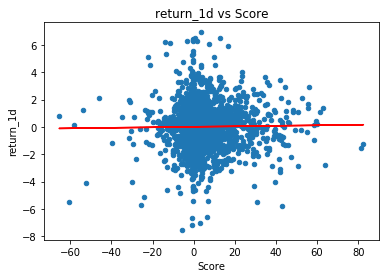

In [23]:
experiment_result('return_1d','Score',price_indicator)

Correlation is : 0.12058490558827523


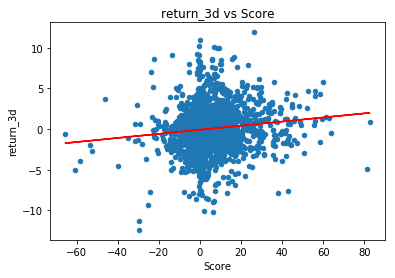

In [24]:
experiment_result('return_3d','Score',price_indicator)

Correlation is : 0.1263000468870899


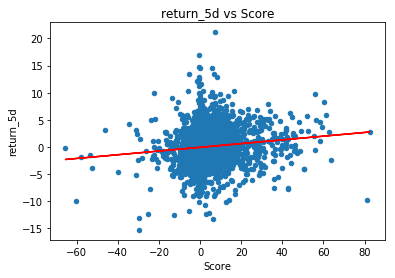

In [25]:
experiment_result('return_5d','Score',price_indicator)

Correlation is : 0.12951210984825273


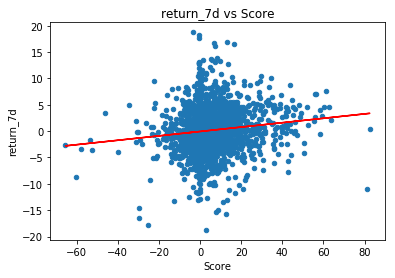

In [26]:
experiment_result('return_7d','Score',price_indicator)

Correlation is : 0.12363652749303425


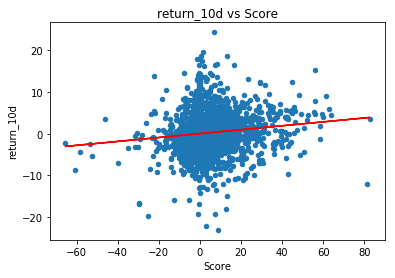

In [27]:
experiment_result('return_10d','Score',price_indicator)

# Conclusion
1. We can see there is a positive correlation between the previous return and sentiment score 
2. It might imply that the score is not random 

# Experiment relationship between forward return ratio and indicator 

In [28]:
price_forward = price.copy()

In [29]:
price_forward['return_1d'] = price_forward['return_1d'].shift(-1)
price_forward['return_3d'] = price_forward['return_3d'].shift(-3)
price_forward['return_5d'] = price_forward['return_5d'].shift(-5)
price_forward['return_7d'] = price_forward['return_7d'].shift(-7)
price_forward['return_10d'] = price_forward['return_10d'].shift(-10)
price_forward['return_15d'] = price_forward['return_15d'].shift(-15)
price_forward['return_20d'] = price_forward['return_20d'].shift(-20)

In [30]:
price_indicator_forward = indicator1.merge(price_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Index',axis=1,inplace = True)
price_indicator_forward = price_indicator_forward.dropna()

Correlation is : -0.004855854651227187


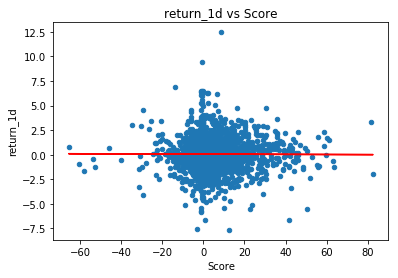

In [31]:
experiment_result('return_1d','Score',price_indicator_forward)

Correlation is : 0.023726821131365847


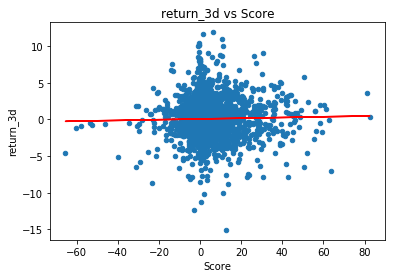

In [32]:
experiment_result('return_3d','Score',price_indicator_forward)

Correlation is : 0.058690834296657814


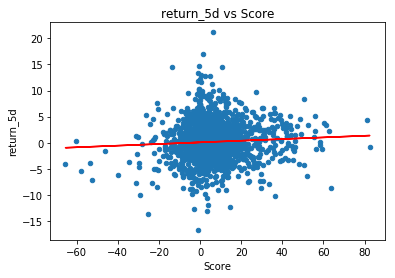

In [33]:
experiment_result('return_5d','Score',price_indicator_forward)

Correlation is : 0.06496668062191574


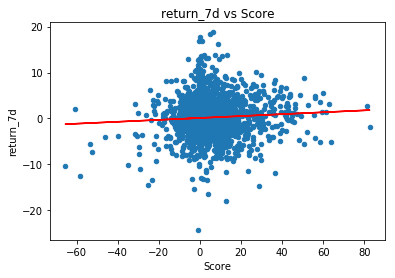

In [34]:
experiment_result('return_7d','Score',price_indicator_forward)

Correlation is : 0.0722100004527315


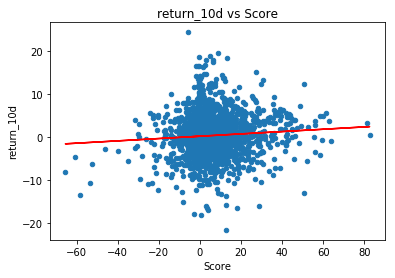

In [35]:
experiment_result('return_10d','Score',price_indicator_forward)

## Conclusion  2
From the experiment above, we can tell sentiment score has zero correlation with future return. However, we can't conclude that it has zero predictive value in it. We will do other testing in next section 

# Experiment relationship between deviation from long term volatility and indicator 

In [43]:
vol = price[[u'Index', u'LMCADY', u'return_1d']].copy()
vol['Std_st'] = (vol[u'return_1d'].rolling(10).std())
vol['Std_lt'] = (vol[u'return_1d'].rolling(250).std())
vol['Std'] = (vol['Std_st']-vol['Std_lt'])
vol['std_1d'] = vol['Std'].shift(-1)
vol['std_3d'] = vol['Std'].shift(-3)
vol['std_5d'] = vol['Std'].shift(-5)
vol['std_7d'] = vol['Std'].shift(-7)
vol['std_10d'] = vol['Std'].shift(-10)
vol.dropna(inplace=True)

In [44]:
vol_indicator = indicator1.merge(vol, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Date',axis=1,inplace = True)
vol_indicator.drop('Index',axis=1,inplace = True)
vol_indicator.dropna(inplace=True)

Correlation is : -0.017343985757564358


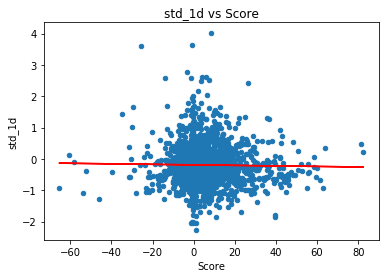

In [45]:
experiment_result('std_1d','Score',vol_indicator)

Correlation is : -0.02377533655228377


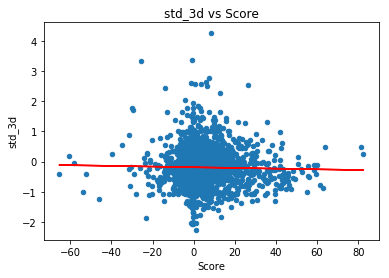

In [46]:
experiment_result('std_3d','Score',vol_indicator)

Correlation is : -0.04036985323340015


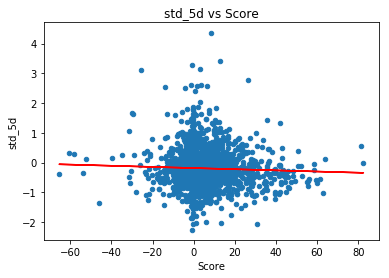

In [47]:
experiment_result('std_5d','Score',vol_indicator)

Correlation is : -0.04276426054571561


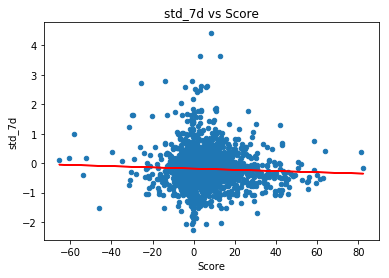

In [48]:
experiment_result('std_7d','Score',vol_indicator)

Correlation is : -0.0586657842038892


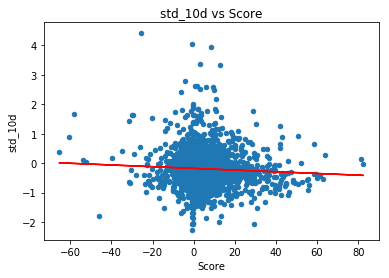

In [49]:
experiment_result('std_10d','Score',vol_indicator)

# Simple price prediction using indicator

In the following section, we will use the indicator to do simple prediction for different time horizon. The logis is as following:

1. If the indicator sign is bigger or equal to zero, we predict positive return for each time horizon
2. Else, negaive for each time horizon

Define a function to give positive sign to data point bigger than zero and negative sign to data point smaller than zero

In [52]:
def give_sign (data):
    if data>=0:
        return 1
    else:
        return -1

In [53]:
# Input: data is the total dataframe, result is the col name of the target return and indicator is the col name of the predictive score
# Obj: This fucntion will give us a the result of the simple prediction strategy

def prediction(result,data,indicator):
    indi_1 = data[indicator].copy()
    sign_indi1 = indi_1.apply(give_sign) 
    sign_return = data[result].apply(give_sign)
    same_result_1= sign_return*sign_indi1
    reverse_result_1 = -sign_indi1*sign_return
    
    
    print('Number of positive in '+ result+ " : "+str(round(sign_return.value_counts()[1]/float(len(sign_return)),6)))
    print('Number of negative in '+ result+ " : "+str(round(sign_return.value_counts()[-1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 1 ' + result+ " : "+str(round(same_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 1 '+ result+ " : "+str(round(reverse_result_1.value_counts()[1]/float(len(sign_return)),6)))

In [54]:
prediction('return_1d',price_indicator_forward,'Score')

Number of positive in return_1d : 0.510334
Number of negative in return_1d : 0.489666
Accuracy for following the same sign of Indicator 1 return_1d : 0.495495
Accuracy for following the reverse sign of Indicator 1 return_1d : 0.504505


In [55]:
prediction('return_3d',price_indicator_forward,'Score')

Number of positive in return_3d : 0.496555
Number of negative in return_3d : 0.503445
Accuracy for following the same sign of Indicator 1 return_3d : 0.487016
Accuracy for following the reverse sign of Indicator 1 return_3d : 0.512984


In [56]:
prediction('return_5d',price_indicator_forward,'Score')

Number of positive in return_5d : 0.504505
Number of negative in return_5d : 0.495495
Accuracy for following the same sign of Indicator 1 return_5d : 0.489666
Accuracy for following the reverse sign of Indicator 1 return_5d : 0.510334


In [57]:
prediction('return_7d',price_indicator_forward,'Score')

Number of positive in return_7d : 0.506624
Number of negative in return_7d : 0.493376
Accuracy for following the same sign of Indicator 1 return_7d : 0.482247
Accuracy for following the reverse sign of Indicator 1 return_7d : 0.517753


In [58]:
prediction('return_10d',price_indicator_forward,'Score')

Number of positive in return_10d : 0.510334
Number of negative in return_10d : 0.489666
Accuracy for following the same sign of Indicator 1 return_10d : 0.496555
Accuracy for following the reverse sign of Indicator 1 return_10d : 0.503445


In [59]:
prediction('return_15d',price_indicator_forward,'Score')

Number of positive in return_15d : 0.525172
Number of negative in return_15d : 0.474828
Accuracy for following the same sign of Indicator 1 return_15d : 0.506094
Accuracy for following the reverse sign of Indicator 1 return_15d : 0.493906


In [60]:
prediction('return_20d',price_indicator_forward,'Score')

Number of positive in return_20d : 0.531002
Number of negative in return_20d : 0.468998
Accuracy for following the same sign of Indicator 1 return_20d : 0.483307
Accuracy for following the reverse sign of Indicator 1 return_20d : 0.516693
